# **Classification of Blood Clot Origins in Ischemic Strokes 🩸**

This notebook explores the task of classifying the etiology of blood clots in whole-slide digital pathology images, specifically identifying whether they are of Cardioembolic (CE) or Large Artery Atherosclerosis (LAA) origin. Through an extensive exploratory data analysis (EDA), we describe the dataset, analyze missing and duplicate values, examine the distribution of image sizes, classify variables, and review the label distribution for the training set, along with plenty of other analysis. This EDA provides a comprehensive understanding of the data and helps identify potential preprocessing steps for optimal model performance.

Following the EDA, we preprocess the images to standardize them for model input. The preprocessing involves resizing, converting images to grayscale, normalizing pixel values, and applying Gaussian blur to reduce noise. These steps ensure that the images are suitable for a Convolutional Neural Network (CNN) by preparing them with a consistent size, format, and reduced noise, enabling more efficient training and improved classification accuracy.

**Authors:**
- [Daniel Valdez](https://github.com/Danval-003)
- [Emilio Solano](https://github.com/emiliosolanoo21)
- [Adrian Flores](https://github.com/adrianRFlores)
- [Andrea Ramírez](https://github.com/Andrea-gt)

***

## **(1) Import Libraries** ⬇️

In [2]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import subprocess
from PIL import Image
import tifffile as tifi
import cv2
import tensorflow as tf
from tqdm import tqdm
from openslide import OpenSlide

# Set the maximum allowable pixels to a higher number.
Image.MAX_IMAGE_PIXELS = None

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **(2) Data Upload** 📄

In [3]:
# Note:
# -----
# For this specific task, we are only using the training data (`train.csv`) throughout most of our analysis.
# The test dataset (`test.csv`) will not be used until the very end when making final predictions.
# We will train, validate, and tune your model using the training data only.
#
# The reason the test data is only used at the very end is to prevent any bias during model training and evaluation.
# We want the test data to remain completely unseen until after we've finalized our model so that it can serve
# as a true evaluation of our model's performance.
# ---------------------------------------------

df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')  # Load the training data
df.head()  # Display the first 5 rows of the DataFrame for a quick inspection of the data

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


## **(3) Exploratory Analysis** 🔎

### **(1) Descripción de los Datos**

In [4]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 754 registers and 5 columns.


**Observaciones 💡 -->**
> - El conjunto de datos contiene más de mil imágenes de patología digital de alta resolución de diapositivas completas. Cada diapositiva representa un coágulo de sangre de un paciente que sufrió de un accidente cerebrovascular isquémico agudo. 

> - En el conjunto `train.csv`, con el que se trabajará por el momento, se cuenta con 754 registros y 5 columnas, lo que indica que tiene una dimensión relativamente pequeña. Cada uno de los 754 registros representa una anotación única con relación a una de las imágenes dentro del directorio `train/`.

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data)

In [5]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


- `image_id`: Un identificador único para la instancia, con el formato {patient_id}_{image_num}. Corresponde a la imagen {image_id}.tif.
- `center_id`: Identifica el centro médico donde se obtuvo la diapositiva.
- `patient_id`: Identifica al paciente del que se obtuvo la diapositiva.
- `image_num`: Enumera las imágenes de coágulos obtenidas del mismo paciente.
- `label`: La etiología del coágulo, que puede ser CE (embolia cardioembólica) o LAA (ataque isquémico). Este campo es el objetivo de clasificación.

<div class="alert alert-block alert-info">
<b>Nota importante:</b> Las diapositivas que conforman los conjuntos de entrenamiento y prueba representan coágulos con una etiología (es decir, origen) que se conoce como CE (cardioembólica) o LAA (aterosclerosis de grandes arterias).
</div>

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data)

### **(2) Clasificación de Variables**

| Nombre      | Descripción                                                       | Tipo                          |
|-------------|-------------------------------------------------------------------|-------------------------------|
| image_id    | Identificador único de la imagen.                                 | Cualitativa (Nominal)         |
| center_id   | Identificador del centro médico donde se tomó la diapositiva.     | Cualitativa (Nominal)         |
| patient_id  | Identificación del paciente de la diapositiva.                    | Cualitativa (Nominal)         |
| image_num   | Número que indica la secuencia de imágenes de un mismo paciente.  | Cuantitativa (Discreta)       |
| label       | Clasificación del coágulo: CE (cardioembólica) o LAA (aterosclerosis). | Cualitativa (Nominal)    |


**Observaciones 💡**
> - En nuestro conjunto de datos, la mayoría de las variables son de tipo **cualitativo nominal**.

> - Por otro lado, solo una variable es de tipo **cuantitativo discreto**, que corresponde al número de imagen.

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Análisis de Data Faltante**

In [6]:
df.isnull().sum()

image_id      0
center_id     0
patient_id    0
image_num     0
label         0
dtype: int64

**Observaciones 💡**

> - A partir de este breve análisis de los datos faltantes, podemos observar que no hay columnas con valores nulos. Esto significa que no es necesario realizar ningún tipo de imputación en el conjunto de datos. Todas las variables están completamente pobladas, lo que garantiza la integridad de los datos para su análisis posterior.

#### **(2) Previsualización de Imágenes**

In [7]:
# Assuming your DataFrame is named df
base_path = "../input/mayo-clinic-strip-ai/train/"

# Add the full path to the df
df['image_path'] = base_path + df['image_id'] + '.tif'

# Preview the DataFrame to ensure the new column is added correctly
df.head()

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif


**Observaciones 💡**

> - Una de las principales técnicas de preprocesamiento será **incluir el path o la dirección de cada imagen** dentro del DataFrame. Esto permitirá acceder a las imágenes de manera más sencilla, ya que, como se ha mencionado anteriormente, todas las imágenes se encuentran almacenadas en el directorio `train`.

In [7]:
def plot_images(df, num_images=5):
    # Select first n images
    sample_df = df.head(num_images)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    # Flatten axes to make it easier to iterate
    axes = axes.flatten()
    
    for i, (img_path, label) in enumerate(zip(sample_df['image_path'], sample_df['label'])):
        img = Image.open(img_path)
        img.thumbnail((300,300), Image.Resampling.LANCZOS)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

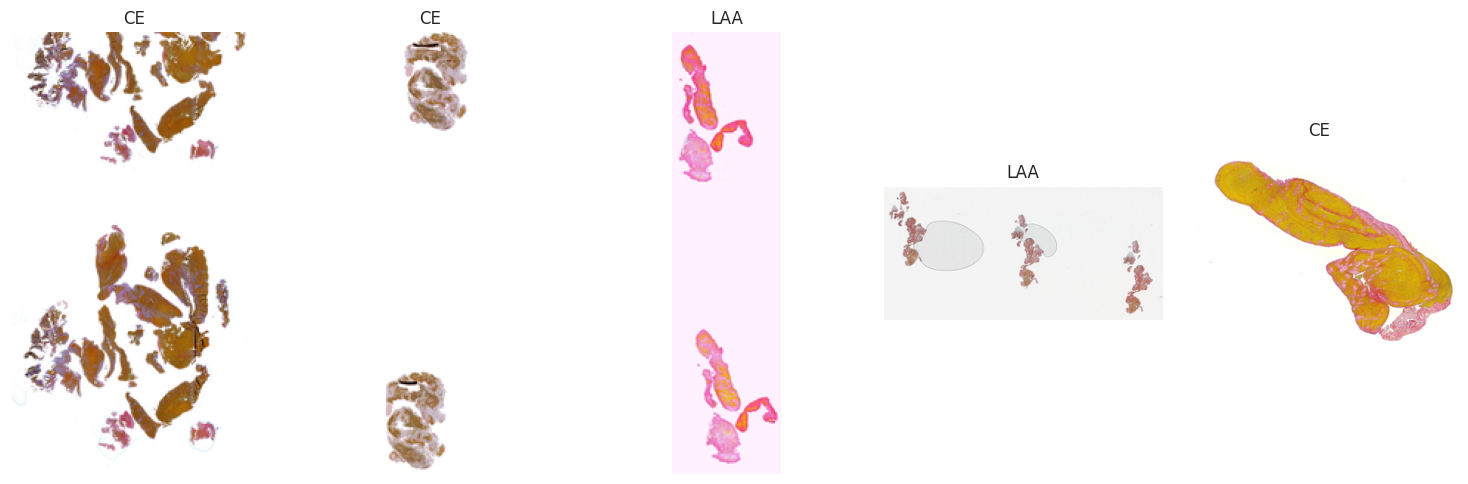

In [8]:
# Show 5 images
plot_images(df)

**Observaciones 💡**

> - Una de las primeras observaciones clave es la gran variabilidad en los tamaños de las imágenes presentes en el conjunto de datos. Estas imágenes muestran diferentes valores de relación de aspecto, lo cual puede presentar desafíos al momento de alimentar estos datos en un modelo predictivo. 

> - También hemos detectado una variación considerable en las características cromáticas de las imágenes. Por ejemplo, algunas de ellas presentan fondos blancos, mientras que otras tienen fondos grises. Esto puede introducir ruido en el modelo si no se trata adecuadamente, ya que los modelos de visión por computadora son sensibles a las variaciones en las condiciones de iluminación y color de las imágenes.

> - Adicionalmente, las imágenes presentan una mezcla de elementos que pueden afectar la precisión del modelo. Algunos coágulos están claramente definidos, mientras que otros están parcialmente oscurecidos o presentan sombras y brillos que pueden confundir al modelo.

Todas extas observaciones reflejan los primeros desafíos que enfrentaremos en el preprocesamiento de imágenes, un paso que se realizará más adelante.

#### **(3) Distribución de Labels**

In [9]:
def label_distribution(df, name='Training Dataframe'):
  label_counts = df['label'].value_counts().sort_index()
  total_counts = label_counts.sum()
    
  # Calculate percentages
  label_percentages = (label_counts / total_counts) * 100
    
  # Plot counts
  plt.plot(1, 2, 1)
  label_counts.plot(kind='bar', color=[palette[0], palette[6]])
  plt.title(f'{name}: Label Counts')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.tight_layout()
  plt.show()

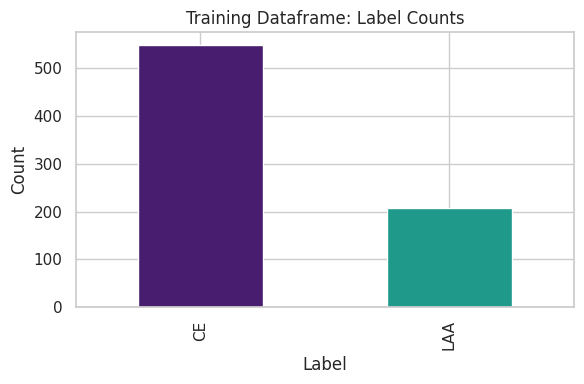

In [10]:
label_distribution(df)

**Observaciones 💡**

> - Nuestro conjunto de datos presenta un **fuerte desbalance**, ya que se cuenta con aproximadamente 550 imágenes de coágulos de **etiología cardioembólica (CE)**, lo que representa más del 70.0% del total de muestras.
  
> - En contraste, solo se disponen de 200 imágenes de coágulos de **etiología aterosclerótica de grandes arterias (LAA)**, lo que corresponde a **menos del 30.0%** del conjunto de datos.

> - Este desequilibrio entre las clases puede tener un impacto negativo en el rendimiento del modelo predictivo, ya que probablemente este se incline a **predecir mayormente la clase CE** debido a la falta de representatividad de la clase LAA. Un modelo sesgado de esta manera podría no capturar adecuadamente las características distintivas de los coágulos LAA, reduciendo su capacidad para hacer predicciones precisas.

> - Para mitigar este problema, se tendrá que explorar técnicas como **submuestreo de la clase mayoritaria**, o el uso de algoritmos tales como **data augmentation**. Aunque esto forma parte de los siguientes pasos a tomar.

#### **(4) Análisis de Tamaños de Imagen**

In [8]:
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size  # Returns (width, height)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Applying the function to the DataFrame
df['image_size'] = df['image_path'].apply(get_image_size)

# Separate width and height if needed
df['width'], df['height'] = zip(*df['image_size'].dropna())

**Observaciones 💡**

> - Como parte del proceso de preprocesamiento de datos, se extraerán las dimensiones (ancho y alto) de cada imagen del DataFrame. Estas dimensiones se almacenarán en dos columnas separadas (width y height) para facilitar el acceso y análisis de esta información. Este paso es importante ya que nos permitirá analizar la distribución de los tamaños de las imágenes, lo cual puede ser útil para determinar de qué manera se deberá redimensionar estas en los próximos pasos.

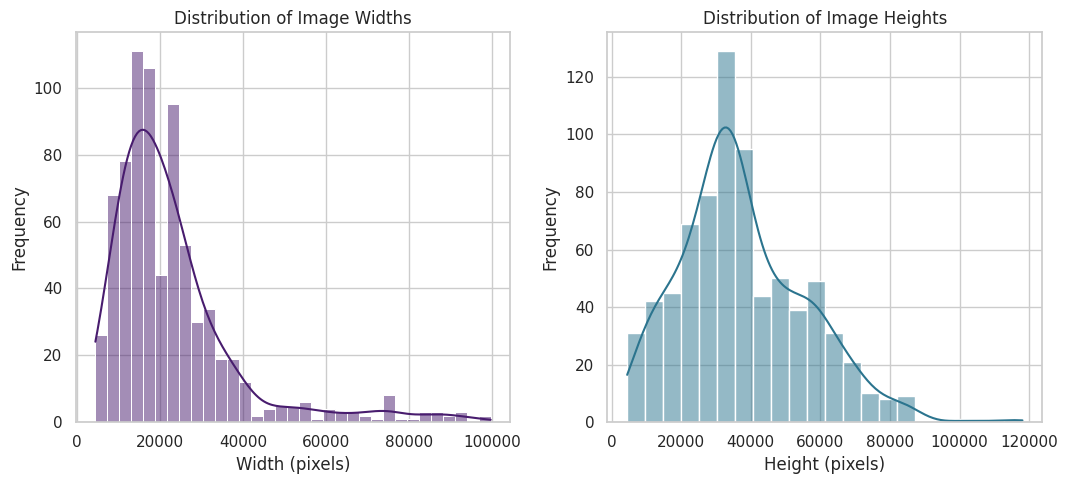

In [12]:
# Set up the plot size and style
plt.figure(figsize=(16, 5))

# Plot the distribution of the width
plt.subplot(1, 3, 1)
sns.histplot(df['width'], kde=True, color=palette[0])
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Plot the distribution of the height
plt.subplot(1, 3, 2)
sns.histplot(df['height'], kde=True, color= palette[4])
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

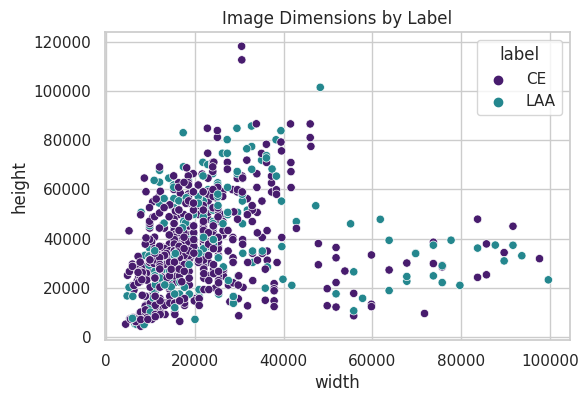

In [13]:
sns.scatterplot(data=df, x='width', y='height', hue='label', palette=[palette[0], palette[5]])
plt.title('Image Dimensions by Label')
plt.show()

In [14]:
# Display descriptive statistics for image dimensions
print("Training Set: Image Width Statistics")
print(df['width'].describe())

print("\nTraining Set: Image Height Statistics")
print(df['height'].describe())

Training Set: Image Width Statistics
count      754.000000
mean     22988.594164
std      15653.642619
min       4417.000000
25%      13215.250000
50%      18700.000000
75%      26376.750000
max      99699.000000
Name: width, dtype: float64

Training Set: Image Height Statistics
count       754.000000
mean      37622.196286
std       18058.750676
min        4470.000000
25%       25402.500000
50%       34981.500000
75%       48919.750000
max      118076.000000
Name: height, dtype: float64


**Observaciones 💡**

> - En estos nuevos gráficos se confirma nuevamente la presencia de múltiples valores tanto en altura como en ancho de las imágenes. La mayoría de las imágenes presentan un ancho concentrado alrededor de los 20,000 píxeles, mientras que la altura se encuentra predominantemente alrededor de los 40,000 píxeles, como lo muestra claramente el histograma.

> - Además, al continuar con este análisis, podemos observar en el diagrama de dispersión que existe una relación predominante entre el tamaño de las imágenes y el tipo de etiología del coágulo del paciente.

> - Se han identificado **datos atípicos**, específicamente en relación con las dimensiones de las imágenes. Sin embargo, estos valores no son de gran relevancia, ya que se normalizarán al redimensionar las imágenes para su inclusión en el modelo.

A continuación veremos cuál es la imagen que posee las dimensiones más grandes y sus detalles.

Largest Image Details:
------------------------------
image_id: 6baf51_0
center_id: 11
patient_id: 6baf51
image_num: 0
label: LAA
image_path: ../input/mayo-clinic-strip-ai/train/6baf51_0.tif
image_size: (48282, 101406)
width: 48282
height: 101406


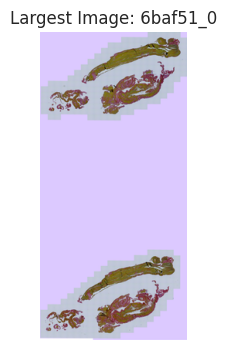

In [15]:
# Find the largest image without creating a new column for area
largest_image_index = (df['width'] * df['height']).idxmax()
largest_image = df.loc[largest_image_index]

# Print the details neatly
print("Largest Image Details:")
print("-" * 30)
for column in df.columns:
    print(f"{column}: {largest_image[column]}")
    
# Open and display the image using Matplotlib
image_path = largest_image['image_path']
img = Image.open(image_path)
img.thumbnail((400,400), Image.Resampling.LANCZOS)

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Largest Image: {largest_image['image_id']}")
plt.show()

del img

#### **(5) Cross-Tab Analysis**

In [16]:
# Create a cross-tabulation of 'center_id' and 'label'
cross_tab = pd.crosstab(df['center_id'], df['label'])

# Display the cross-tabulation table
cross_tab.head()

label,CE,LAA
center_id,,
1,44,10
2,26,3
3,22,27
4,88,26
5,29,9


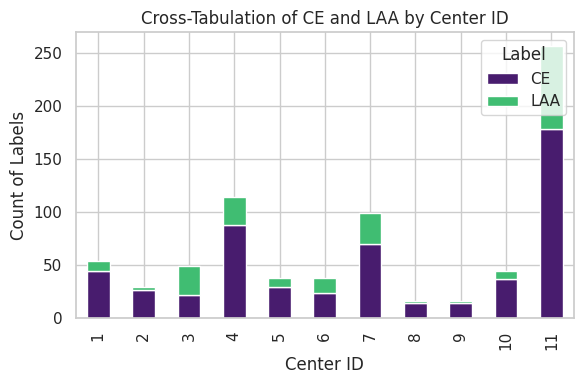

In [17]:
# Plot a stacked bar plot for better visualization
cross_tab.plot(kind='bar', stacked=True, color=[palette[0], palette[8]])

# Adding titles and labels
plt.title('Cross-Tabulation of CE and LAA by Center ID')
plt.xlabel('Center ID')
plt.ylabel('Count of Labels')
plt.legend(title='Label', loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

**Observaciones 💡**

> - El Centro 11 tiene la mayor cantidad de imágenes, predominantemente etiquetadas como CE (179) en comparación con LAA (7). Este desequilibrio significativo sugiere un posible enfoque o especialización en casos cardioembólicos en este centro.

> - El Centro 4 también muestra una fuerte prevalencia de CE con 88 casos frente a 26 casos de LAA.

> - Los Centros 3 y 7 demuestran una distribución más equilibrada, con el Centro 3 teniendo 22 CE y 27 LAA, y el Centro 7 reportando 70 CE frente a 29 LAA. 

> - Otros centros, como el Centro 2 y el Centro 5, presentan un menor número de casos en general, con el Centro 2 mostrando 26 CE y 3 LAA, lo que indica una posible subrepresentación de casos de aterosclerosis de grandes arterias.

Vemos que en general, los datos sugieren que los centros están más especializados en etiologías de accidente cerebrovascular, particularmente en casos **cardioembólicos**.

#### **(6) Tablas de Frecuencia**

In [18]:
# Define a function for formatted printing
def print_frequent_values(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        frequency_values = df[column].value_counts().head(10)
        print(f"\n{'='*50}\nTop 10 most frequent values for column '{column}':")
        print(f"{'Index':<5} {'Value':<30} {'Frequency':<10}")
        print('-' * 50)  # Separator line

        for index, (value, frequency) in enumerate(frequency_values.items(), start=1):
            print(f"{index:<5} {str(value)[:30]:<30} {frequency:<10}")

        print(f"{'='*50}")

In [19]:
# Call the function
print_frequent_values(df)


Top 10 most frequent values for column 'image_id':
Index Value                          Frequency 
--------------------------------------------------
1     ffec5c_1                       1         
2     006388_0                       1         
3     008e5c_0                       1         
4     00c058_0                       1         
5     01adc5_0                       1         
6     026c97_0                       1         
7     028989_0                       1         
8     029c68_0                       1         
9     032f10_0                       1         
10    0372b0_0                       1         

Top 10 most frequent values for column 'center_id':
Index Value                          Frequency 
--------------------------------------------------
1     11                             257       
2     4                              114       
3     7                              99        
4     1                              54        
5     3                  

**Observaciones 💡**

> - Tal como se espera, el valor más frecuente en la columna `center_id` es 11, que aparece 257 veces, lo que indica que es el centro médico principal involucrado en la mayoría de los casos. Otros centros notables incluyen el 4, con 114 ocurrencias, y el 7, con 99.

> - En la columna `patient_id`, los IDs más frecuentes (por ejemplo, 91b9d3, 3d10be y 09644e) aparecen cada uno 5 veces, lo que indica que estos pacientes tienen múltiples imágenes tomadas para análisis. Esta repetición sugiere un posible enfoque en pacientes específicos con imágenes recurrentes, posiblemente debido a un seguimiento continuo de condiciones particulares. 

> - Finalmente, la columna `image_num` muestra que 0 es el valor más común, con 632 ocurrencias, lo que sugiere que el conjunto de datos consiste principalmente en las primeras imágenes tomadas de varios pacientes. Los valores posteriores, con 1 apareciendo 89 veces y 2 solo 21 veces, indican que hay menos imágenes subsiguientes por paciente. Este patrón podría sugerir que la mayoría de los casos implican evaluaciones iniciales en lugar de imágenes de seguimiento.

#### **(7) Análisis de Pacientes**

In [20]:
# Count unique patients
unique_patient_count = df['patient_id'].nunique()

# Print the result neatly
print(f"Unique Patients Count: {unique_patient_count}")

Unique Patients Count: 632


> - Como se ha mencionado anteriormente, solamente algunos pacientes tienen más de una imagen asociada a su persona, por lo que en nuestro conjunto de datos hay imágenes de 630 pacientes **únicos**.

#### **(8) Análisis de Valores Duplicados**

In [21]:
# Check duplicate rows in dataset
df = df.drop_duplicates()
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 754 registers and 9 columns.


> - Vemos que no existen valores duplicados en el conjunto de datos.

## **(4) Image Preprocessing 📷**

In [17]:
def preprocess(image_path):
    slide = OpenSlide(image_path)
    region = (1000, 1000)    
    size = (5000, 5000)
    image = slide.read_region(region, 0, size)
    # Resize the image
    image = tf.image.resize(image, (512, 512))
    # Convert to a numpy array
    image = np.array(image)
    # Convert the image to grayscale
    grayscale_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # RGB to Grayscale
    # Reason: Convert to grayscale if the model is designed for single-channel input.
    # Normalize pixel values to the range [0, 1]
    normalized_image = grayscale_image / 255.0

    return normalized_image

In [20]:
%%time

x_train = []  # Initialize an empty list to store preprocessed images

# Loop through each file path in the training DataFrame
for i in tqdm(df['image_path'], 
              bar_format='[{elapsed}<{remaining}] {n_fmt}/{total_fmt} | {l_bar}{bar} {rate_fmt}{postfix}', 
              colour='#dd2680'):
    x1 = preprocess(i)  # Call the preprocess function for the current file path
    x_train.append(x1)  # Append the processed image to the x_train list

[42:20<00:00] 754/754 | 100%|██████████  3.37s/it

CPU times: user 14min 12s, sys: 4min 55s, total: 19min 8s
Wall time: 42min 20s


**Observaciones 💡 -->**

1. **Conversión a Escala de Grises**
   - **Código**: `img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`
   - **Descripción**: Convierte la imagen de color (BGR) a una imagen en escala de grises.
   - **Propósito**: Reducir la complejidad del modelo ya que se espera una entrada de un solo canal (grayscale). Permitirá que el entrenamiento sea más rápido.

2. **Normalización de Valores de Pixel**
   - **Código**: `img = img / 255.0`
   - **Descripción**: Normaliza los valores de los píxeles a un rango de [0, 1].
   - **Propósito**: Normalizar los valores de los píxeles asegura que estén en un rango consistente, lo que ayuda a mantener una iluminación y contraste uniformes en todas las imágenes. Esto facilita la comparación de patrones y características, haciendo que las imágenes sean más adecuadas para el análisis. Además, permite que los modelos de aprendizaje automático aprendan patrones de manera más efectiva, sin que las diferencias en las condiciones de iluminación afecten el rendimiento.

3. **Aplicación de Desenfoque Gaussiano**
   - **Código**: `img = cv2.GaussianBlur(img, (5, 5), 0)`
   - **Descripción**: Aplica un filtro de desenfoque gaussiano para reducir el ruido en la imagen.
   - **Propósito**: El desenfoque gaussiano reduce el detalle y el ruido en la imagen aplicando una función gaussiana a cada píxel y sus píxeles circundantes. Esto suaviza los bordes y elimina pequeños detalles que pueden no ser útiles para el aprendizaje, ayudando a la red neuronal a centrarse en las características más relevantes. La reducción de ruido mejora la capacidad de generalización del modelo y puede facilitar tareas como la detección de bordes o la segmentación al reducir las variaciones no deseadas en la imagen.

4. **Expansión de Dimensiones**
   - **Código**: `img = np.expand_dims(img, axis=-1)`
   - **Descripción**: Expande las dimensiones de la imagen para agregar un canal adicional.
   - **Propósito**: Asegura que la imagen tenga un formato consistente para la entrada de la red neuronal, especialmente si la red espera una entrada con un número específico de canales (por ejemplo, [alto, ancho, canales]).
   
5. Redimensionamiento de Imagen
   - **Código**: img = cv2.resize(img, (0,0), fx=0.05, fy=0.05)
   - **Descripción**: Redimensiona la imagen aplicando un factor de escala del 5% en los ejes horizontal (fx) y vertical (fy).
   - **Propósito**: Reduce el tamaño de la imagen para disminuir la cantidad de información que se procesa en la red neuronal convolucional (CNN), lo que puede ser útil para ahorrar recursos computacionales o ajustar la entrada a las dimensiones esperadas por el modelo.

**Referencia**
> - https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c

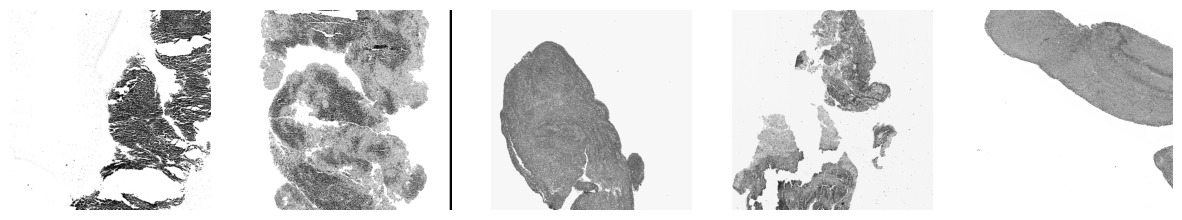

In [21]:
# Create a figure with subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Loop through the first few images in x_train and plot them
for ax, img in zip(axes, x_train[:5]):
    ax.imshow(img, cmap='gray')  # Display the image in grayscale
    ax.axis('off')  # Turn off axis labels

plt.show()  # Show the plot

## **(5) Data Splitting Process ✂️**

## 